In [2]:
import scanpy as sc
import episcanpy as epi
import numpy as np
import sklearn
import pandas as pd 
import torch
from Fountain.data import create_dataloader,create_batchind_dict
from Fountain.fountain import Fountain
import scib
from Fountain.data import create_dataloader,create_batchind_dict
#import Fountain.layer
from Fountain.fountain import Fountain
from Fountain.utils import cluster_evaluation
from Fountain.utils import overcorrection_score

import matplotlib.pyplot as plt

You can directly download the [human.h5ad](https://drive.google.com/file/d/13WEORnZBp7qGwi3DkrlSgE--4AA3kV42/view?usp=drive_link) and [monkey.h5ad](https://drive.google.com/file/d/13WEORnZBp7qGwi3DkrlSgE--4AA3kV42/view?usp=drive_link) here.


In [4]:
adata1 = sc.read("human.h5ad")
adata2 = sc.read("monkey.h5ad")

In [5]:
adata1

AnnData object with n_obs × n_vars = 20673 × 19817
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'NAME', 'cell_type', 'batch', 'n_genes', 'celltype'
    var: 'n_cells'
    uns: 'log1p'

In [6]:
adata2

AnnData object with n_obs × n_vars = 4410 × 15847
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'NAME', 'cell_type', 'batch', 'n_genes', 'celltype'
    var: 'n_cells'
    uns: 'log1p'

In [9]:
# combine these two datasets
adata_combined = adata1.concatenate(adata2, batch_key='Species', uns_merge='same')
adata_combined.obs['Species'] = adata_combined.obs['Species'].replace({0: 'Human', 1: 'Monkey'})
print(adata_combined)



See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html


AnnData object with n_obs × n_vars = 25083 × 11311
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'NAME', 'cell_type', 'batch', 'n_genes', 'celltype', 'Species'
    var: 'n_cells-0', 'n_cells-1'


In [19]:
adata_combined.obs['Species'] = adata_combined.obs['Species'].astype(str).replace({'0': 'Human', '1': 'Monkey'})
print(adata_combined.obs['Species'])


H1TMS1_AAACCTGAGCGTTCCG.1-0           Human
H1TMS1_AAACCTGAGGTAGCTG.1-0           Human
H1TMS1_AAACCTGAGTTGTAGA.1-0           Human
H1TMS1_AAACCTGCAGCTGTAT.1-0           Human
H1TMS1_AAACCTGCAGGAATCG.1-0           Human
                                      ...  
MacaTMRimLS1_TTTCGATAGTGCACAG.1-1    Monkey
MacaTMRimLS1_TTTCGATCAAGAAATC.1-1    Monkey
MacaTMRimLS1_TTTCGATTCCTATTGT.1-1    Monkey
MacaTMRimLS1_TTTGATCTCGCAGTGC.1-1    Monkey
MacaTMRimLS1_TTTGTTGTCGAGTTGT.1-1    Monkey
Name: Species, Length: 25083, dtype: object


Follow the preprocess progress for scRNA-seq dataset in [Scanpy tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html).

In [20]:
adata = adata_combined
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata_rna_index = sc.pp.highly_variable_genes(adata, n_top_genes=2000, inplace=False, subset=True)
adata_hvg = adata[:,adata_rna_index.index]

In [21]:
adata_hvg

View of AnnData object with n_obs × n_vars = 25083 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'NAME', 'cell_type', 'batch', 'n_genes', 'celltype', 'Species'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'log1p'

In [22]:
adata1  = adata_hvg
sc.tl.pca(adata1)
sc.pp.neighbors(adata1, n_neighbors=15, use_rep="X_pca")
sc.tl.umap(adata1)


<Axes: title={'center': 'cell_type'}, xlabel='UMAP1', ylabel='UMAP2'>

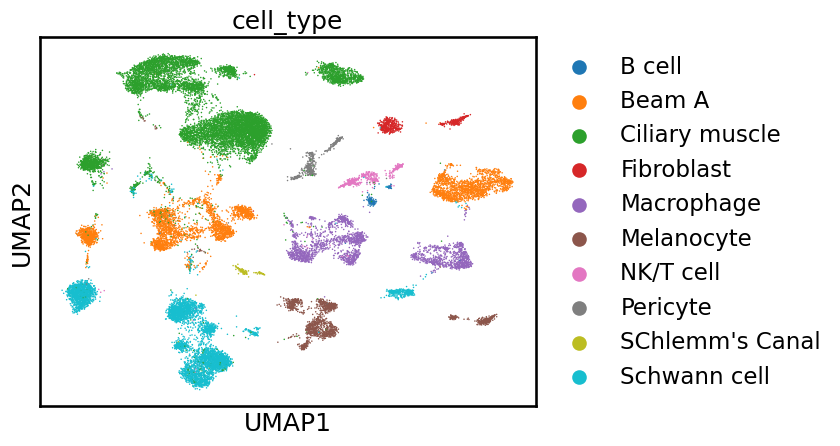

In [24]:
sc.pl.umap(adata1, color=['cell_type'],show=False,color_map='viridis')

<Axes: title={'center': 'Species'}, xlabel='UMAP1', ylabel='UMAP2'>

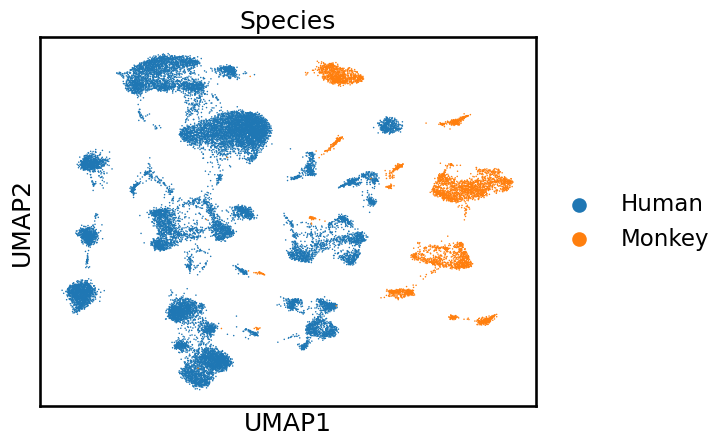

In [23]:
sc.pl.umap(adata1, color=['Species'],show=False,color_map='viridis')

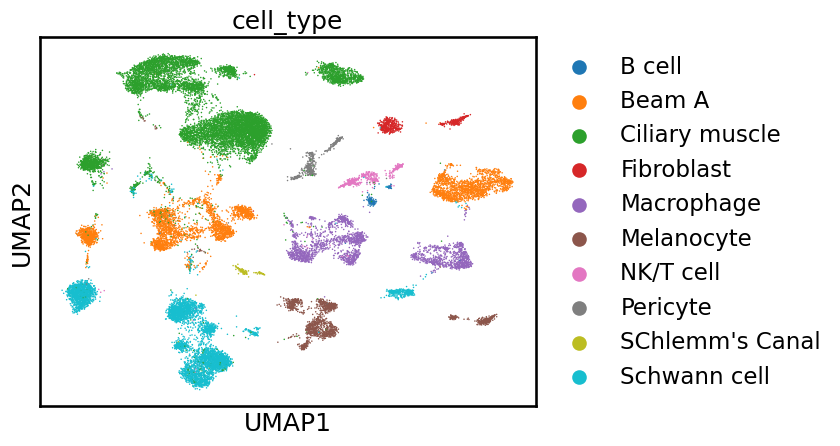

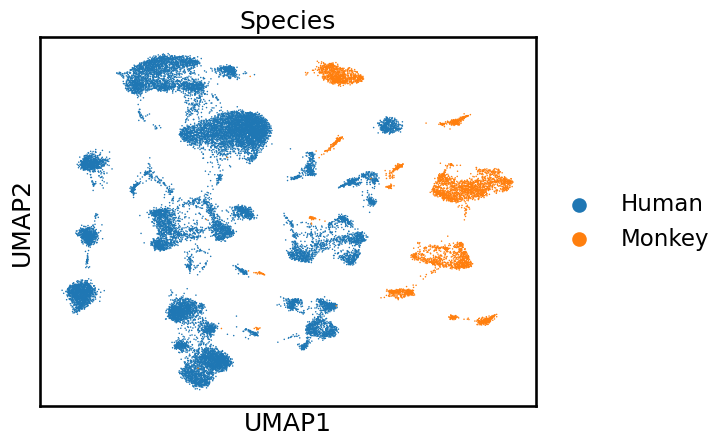

In [25]:
save_folder = "/umap/RNA/"
import os
sc.pl.umap(adata1, color=['cell_type'],show=False,color_map='viridis')
plt.savefig(os.path.join(save_folder, 'umap_Original_HM_cell_type.pdf'), dpi=300, format='pdf', bbox_inches='tight', transparent=True)
sc.pl.umap(adata1, color=['Species'],show=False,color_map='viridis')
plt.savefig(os.path.join(save_folder, 'umap_Original_HM_batch.pdf'), dpi=300, format='pdf', bbox_inches='tight', transparent=True)


Apply Fountain to correct batch effects in this scRNA-seq dataset.

In [21]:
import scipy
adata =adata_hvg
adata.X = scipy.sparse.csr_matrix(adata.X)  

batchind_dict=create_batchind_dict(adata ,batch_name='Species')
batchsize=min(128*len(batchind_dict),1024)
dataloader=create_dataloader(adata,batch_size=batchsize,batchind_dict=batchind_dict,batch_name='Species',num_worker=4,droplast=False)
enc=[['fc', 1024, '', 'gelu'],['fc', 256, '', 'gelu'],['fc', 16, '', '']]
dec=[['fc', 512, '', 'gelu'],['fc', adata.X.shape[1], '', '']]
early_stopping= None
device='cuda:3'

In [23]:


model=Fountain(adata,enc,dec, n_domain=len(create_batchind_dict(adata,batch_name='Species')),batch_name='Species')
model.train(            
          dataloader,             
          lambda_mse=0.005, 
          lambda_Eigenvalue=0.5,
          max_iteration=30000,
          mid_iteration=3000,
          #loss='multinomial',
          early_stopping=early_stopping,
          device=device, 
      )

Epochs: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 307/307 [18:33<00:00,  3.63s/it, recon_loss=520.953,kl_loss=22.189,mse_loss=4.675]


In [24]:
emb='fountain'
adata.obsm[emb]=model.get_latent(dataloader,device=device)

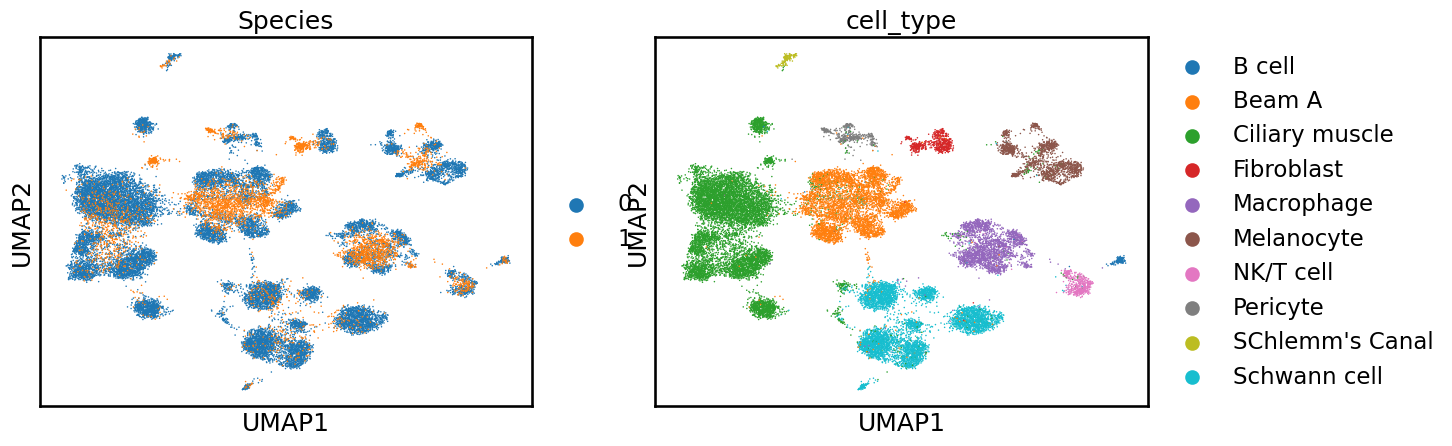

In [25]:
sc.pp.neighbors(adata, use_rep='fountain')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Species','cell_type'])

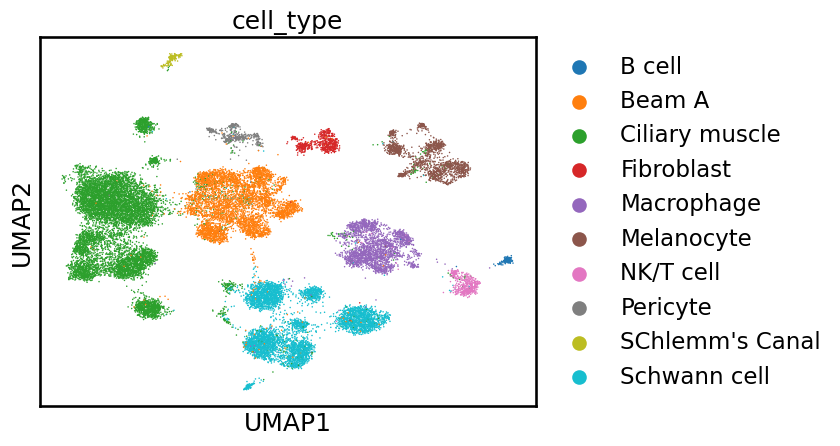

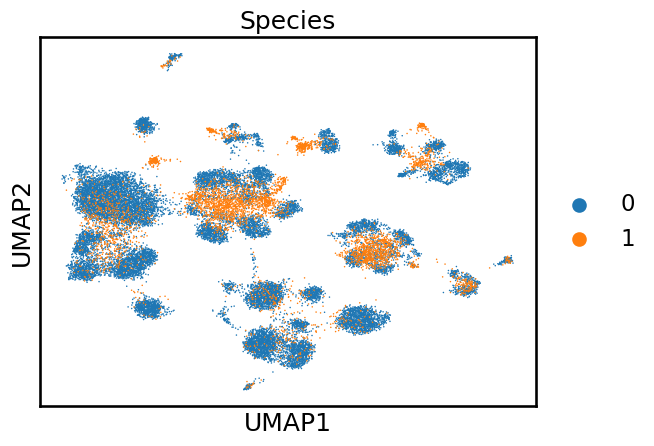

In [26]:
save_folder = "/umap/RNA/"
import os
sc.pl.umap(adata, color=['cell_type'],show=False,color_map='viridis')
plt.savefig(os.path.join(save_folder, 'umap_HM_cell_type.pdf'), dpi=300, format='pdf', bbox_inches='tight', transparent=True)
sc.pl.umap(adata, color=['Species'],show=False,color_map='viridis')
plt.savefig(os.path.join(save_folder, 'umap_HM_batch.pdf'), dpi=300, format='pdf', bbox_inches='tight', transparent=True)
